# 1.Setup

In [323]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time # Untuk mengukur waktu GridSearchCV

from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## 1.1 Create Helper Functions

In [ ]:
def create_question_feature(text_series):
    """
    Membuat fitur biner yang menandakan apakah sebuah teks mengandung tanda tanya '?'.
    Menggunakan metode .str.contains() yang lebih efisien.
    """
    if not isinstance(text_series, pd.Series):
        text_series = pd.Series(text_series)
    # regex=False memastikan pencarian literal untuk '?'
    return text_series.str.contains(r'\?', regex=True).astype(int).values.reshape(-1, 1)

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """
    Membuat dan menampilkan plot confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    # Mendapatkan label nama sentimen
    target_names = [key for key, val in sorted(sentiment_label_to_int.items(), key=lambda item: item[1])]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# 2.Load Dataset

In [ ]:
FILE_PATH = "tweet_bersih.csv"
TEST_SIZE = 0.2
RANDOM_STATE = 16

try:
    df = pd.read_csv(FILE_PATH)
    print('Dataset berhasil dimuat')
    print(f'Jumlah data: {len(df)} baris')
except FileNotFoundError:
    print(f"Error: File tidak ditemukan di '{FILE_PATH}'. Pastikan path sudah benar")
    exit()

Dataset berhasil dimuat
Jumlah data: 1815 baris


# 3.Preparing Data

In [326]:
X_text = df['tweet_bersih'].fillna('') # Mengisi NaN dengan string kosong
y_labels = df['sentimen']
sentiment_label_to_int = {'negatif': 0, 'netral': 1, 'positif': 2}
y = y_labels.map(sentiment_label_to_int)

X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_text, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y
)
print(f'Ukuran data latih: {len(X_text_train)} baris')
print(f'Ukuran data uji: {len(X_text_test)} baris')

Ukuran data latih: 1452 baris
Ukuran data uji: 363 baris


# 4. Create and Train the Model using Pipeline & GridSearchCV

In [ ]:
print("\n--- Menggunakan scikit-learn Pipeline & GridSearchCV ---")

# Mendefinisikan pipeline untuk ekstraksi fitur gabungan
feature_extraction = FeatureUnion([
    ('tfidf', TfidfVectorizer(max_features=800, min_df=5, ngram_range=(1, 3))),
    # FunctionTransformer digunakan untuk mengaplikasikan fungsi Python kustom (create_question_feature)
    ('question_feature', FunctionTransformer(create_question_feature, validate=False))
])

# Buat pipeline utama yang menggabungkan ekstraksi fitur dan classifier
model_pipeline = Pipeline([
    ('features', feature_extraction),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Mendefinisikan grid parameter yang ingin diuji untuk langkah 'classifier' di Pipeline
param_grid = {
    # Perhatikan format penamaan: 'nama_step__nama_parameter'
    'classifier__n_estimators': [50, 100, 200, 300],
    'classifier__max_depth': [5, 10, 20, 30, 50, None],
    'classifier__min_samples_split': [2, 5, 10, 20, 30],
    'classifier__min_samples_leaf': [1, 2, 5, 10]
}

# Buat objek GridSearchCV
grid_search = GridSearchCV(
    estimator=model_pipeline, # Menggunakan Pipeline sebagai estimator
    param_grid=param_grid,
    cv=3, 
    n_jobs=-1, 
    verbose=2, 
    scoring='accuracy'
)

print("Memulai Hyperparameter Tuning dengan GridSearchCV (Pipeline)...")
start_time = time.time()

# Latih GridSearchCV pada data training mentah (X_text_train)
grid_search.fit(X_text_train, y_train)

end_time = time.time()
print(f"GridSearchCV selesai dalam {(end_time - start_time):.2f} detik.")

# Dapatkan model terbaik yang sudah dilatih (Pipeline lengkap)
best_rf_model = grid_search.best_estimator_


--- Menggunakan scikit-learn Pipeline & GridSearchCV ---
Memulai Hyperparameter Tuning dengan GridSearchCV (Pipeline)...
Fitting 3 folds for each of 480 candidates, totalling 1440 fits
GridSearchCV selesai dalam 106.45 detik.


# 5. Prediction and Evaluate the Model


Parameter terbaik yang ditemukan (Model Terbaik):
{'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 20, 'classifier__n_estimators': 300}

--- Hasil Evaluasi Model Random Forest Terbaik (via Pipeline) ---
Akurasi Data Latih : 0.8285
Akurasi Data Uji   : 0.6061

Laporan Klasifikasi Data Uji:
              precision    recall  f1-score   support

     negatif       0.63      0.62      0.63       119
      netral       0.59      0.68      0.63       121
     positif       0.59      0.52      0.55       123

    accuracy                           0.61       363
   macro avg       0.61      0.61      0.60       363
weighted avg       0.61      0.61      0.60       363



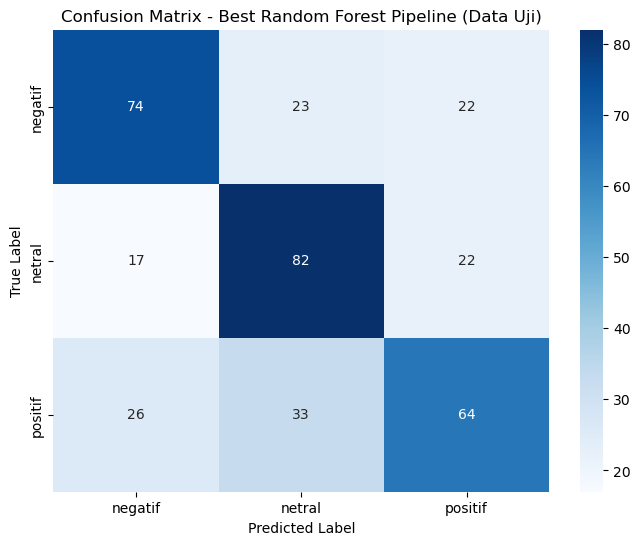

In [328]:
y_pred_test = best_rf_model.predict(X_text_test)
y_pred_train = best_rf_model.predict(X_text_train)

# Tampilkan parameter terbaik
print("\nParameter terbaik yang ditemukan (Model Terbaik):")
print(grid_search.best_params_)

# Menampilkan hasil evaluasi
print("\n--- Hasil Evaluasi Model Random Forest Terbaik (via Pipeline) ---")
print(f"Akurasi Data Latih : {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Akurasi Data Uji   : {accuracy_score(y_test, y_pred_test):.4f}")

target_names = [key for key, val in sorted(sentiment_label_to_int.items(), key=lambda item: item[1])]
print("\nLaporan Klasifikasi Data Uji:")
print(classification_report(y_test, y_pred_test, target_names=target_names))

plot_confusion_matrix(y_test, y_pred_test, classes=target_names, title='Confusion Matrix - Best Random Forest Pipeline (Data Uji)')